# Imports

In [216]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV

# Data

In [179]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

# Features

## Dummies from previous notebook

In [180]:
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

In [181]:
train = process_age(train)
holdout = process_age(holdout)

In [182]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [183]:
for col in ['Age_categories', 'Pclass', 'Sex']:
    train = create_dummies(train, col)
    holdout = create_dummies(holdout, col)

In [184]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male'],
      dtype='object')

## Other features

#### Unused columns
- **SibSp** - The number of siblings or spouses the passenger had aboard the Titanic
- **Parch** - The number of parents or children the passenger had aboard the Titanic
- **Ticket** - The passenger's ticket number
- **Fare** - The fair the passenger paid
- **Cabin** - The passengers cabin number
- **Embarked** - The port where the passenger embarked *(C=Cherbourg, Q=Queenstown, S=Southampton)*

In [185]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


In [186]:
# Rescale data

# Replace missing
train['Embarked'] = train['Embarked'].fillna('S')
holdout['Embarked'] = holdout['Embarked'].fillna('S')

holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

# Make dummies for Embarked
train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

scaled_cols = ['SibSp', 'Parch', 'Fare']
for col in scaled_cols:
    train[col + '_scaled'] = minmax_scale(train[col])
    holdout[col + '_scaled'] = minmax_scale(holdout[col])

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


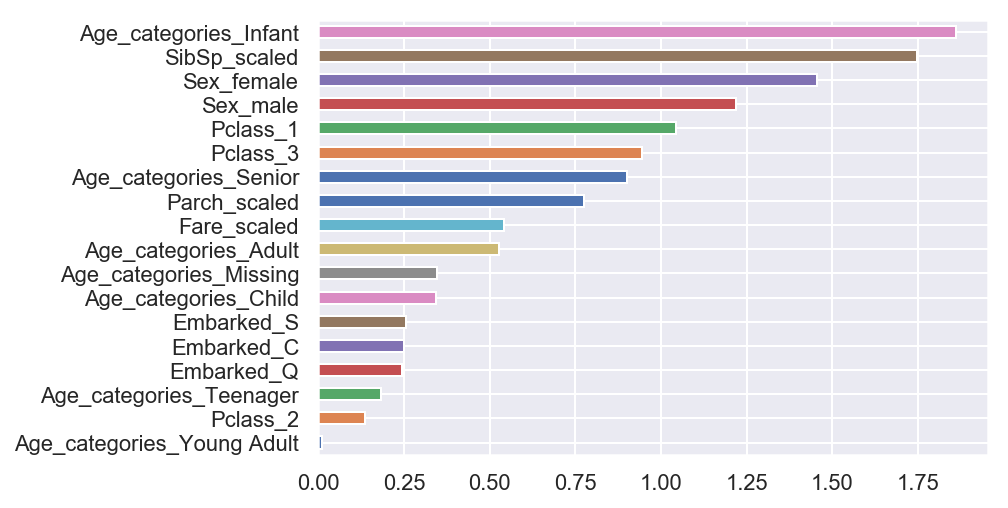

In [217]:
# Find feature relevance

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh();

# Train and test

In [188]:
columns = ordered_feature_importance[ordered_feature_importance > 0.75].index.tolist()

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train['Survived'], cv=10)
accuracy = scores.mean()
accuracy

0.8148019521053229

In [189]:
lr = LogisticRegression()
all_X = train[columns]
all_y = train['Survived']

lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

holdout_ids = holdout['PassengerId']
submission = pd.DataFrame({
    'PassengerId': holdout_ids,
    'Survived': holdout_predictions
})

submission.to_csv('submission_1.csv', index=False)

# Binning

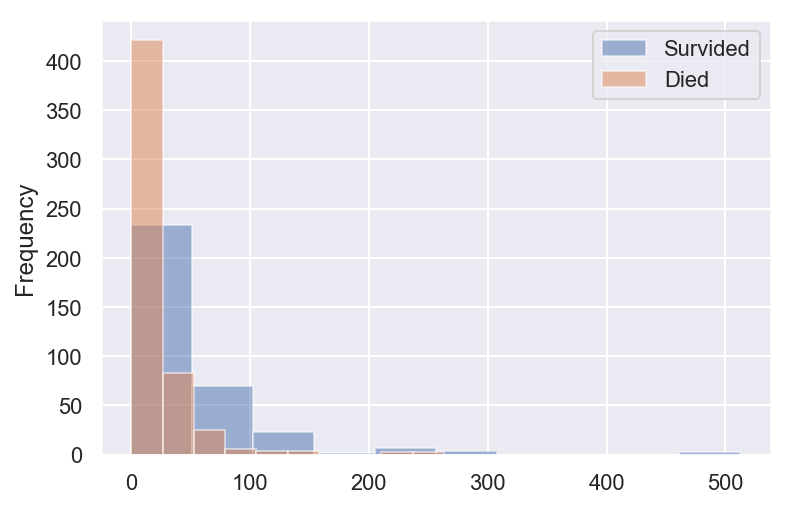

In [190]:
survived = train[train['Survived'] == 1]
died = train[~(train['Survived'] == 1)]

for status in [survived, died]:
    status['Fare'].plot.hist(alpha=0.5)
plt.legend(['Survided', 'Died']);

Let's bin this into
- 0–12
- 12–50
- 50–100
- 100+

In [191]:
def process_fare(df, cut_points, label_names):
    df['Fare_categories'] = pd.cut(df['Fare'], cut_points, labels=label_names)
    return df
cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)

train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

6 types of titles:
- Mr
- Mrs
- Master
- Miss
- Officer
- Royalty

In [192]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

In [193]:
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

In [194]:
train['Cabin_type'] = train['Cabin'].str[0]
train['Cabin_type'] = train['Cabin_type'].fillna('Unknown')
holdout['Cabin_type'] = holdout['Cabin'].str[0]
holdout['Cabin_type'] = holdout['Cabin_type'].fillna('Unknown')

In [195]:
for col in ['Title', 'Cabin_type']:
    train = create_dummies(train, col)
    holdout= create_dummies(holdout, col)

# Check for collinearity

In [230]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

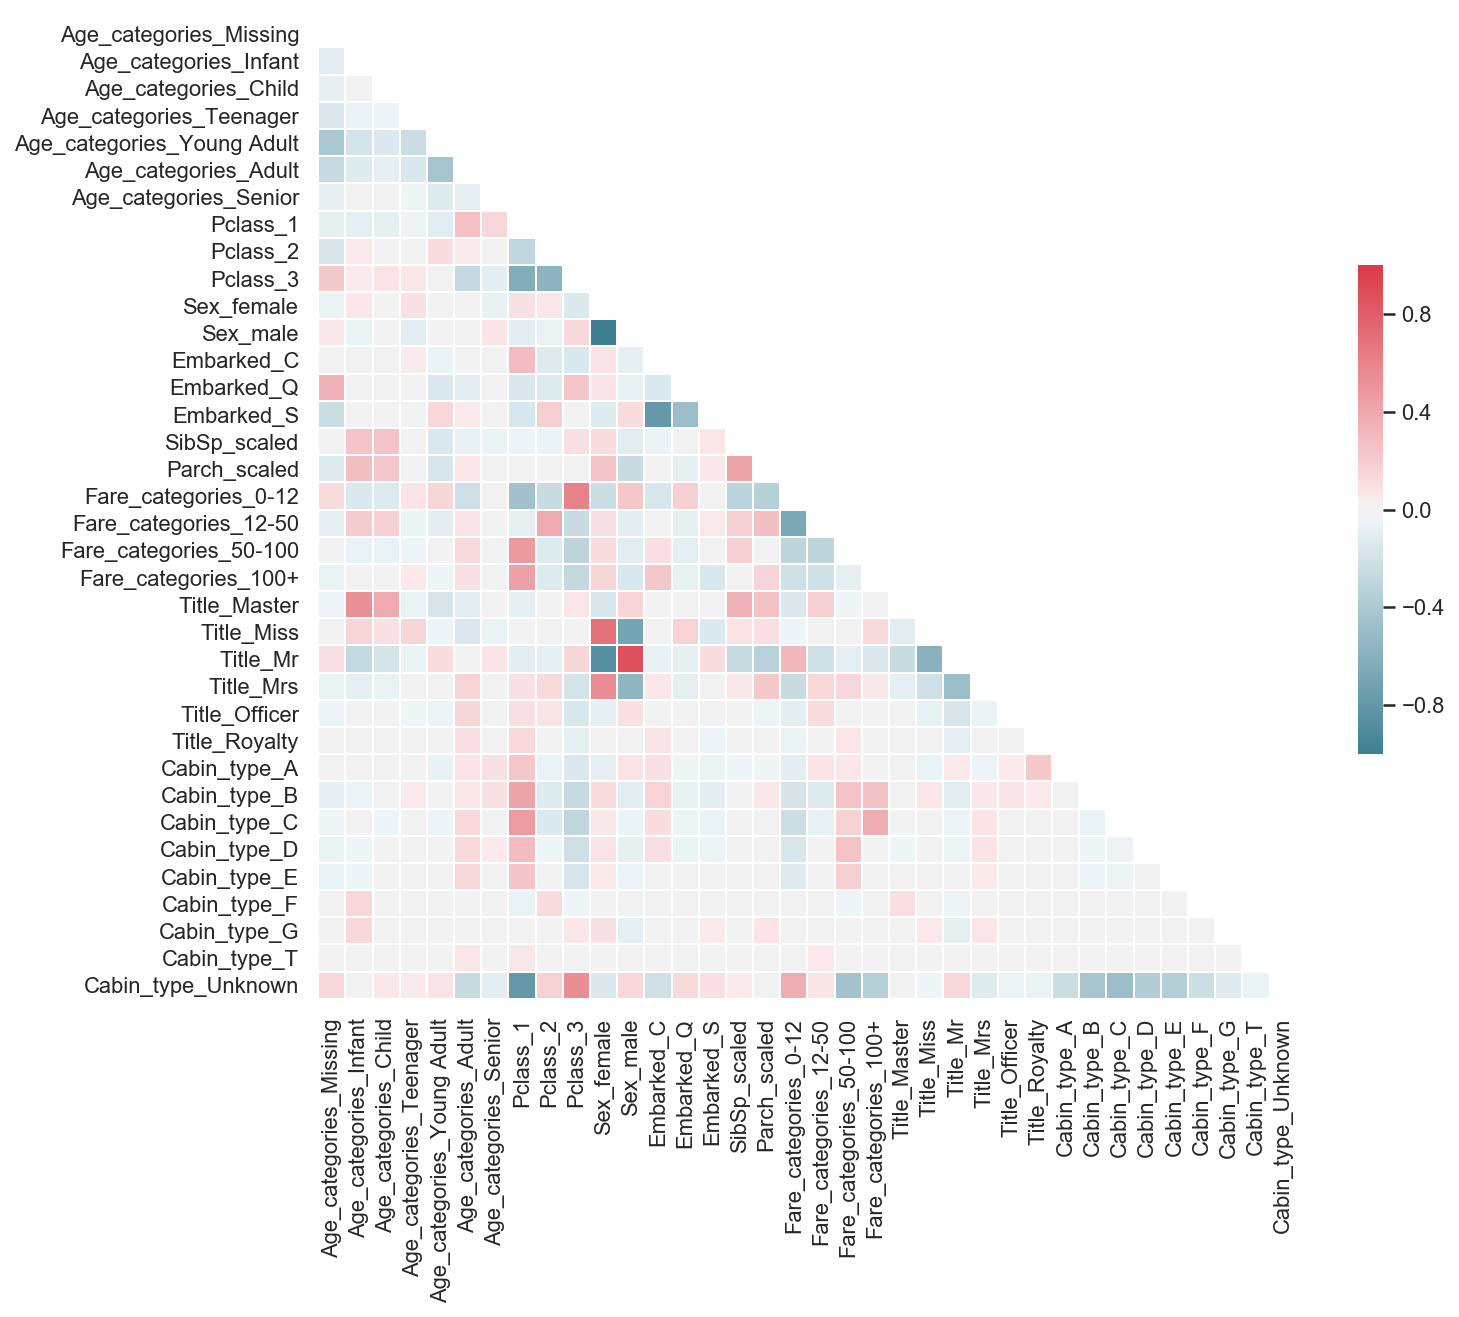

In [231]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']
plot_correlation_heatmap(train[columns]);

Need to remove one of each dummy variables to reduce collinearity—

- `Pclass_2`
- `Age_categories_Teenager`
- `Fare_categories_12-50`
- `Title_Master`
- `Cabin_type_A`

Also remove `Sex_female` and `Sex_male` since they correlate with some titles

In [232]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)
optimized_columns = all_X.columns[selector.support_]
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

# Train and test

In [239]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

0.8226549199863807

In [240]:
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])
submission = pd.DataFrame(
    {'PassengerId': holdout['PassengerId'],
     'Survived': holdout_predictions})
submission.to_csv('submission_2.csv', index=False)